## for random nearby genes, how much variance does each pc explain?

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.stats import spearmanr




import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
from notebook_helper_functions import *
import annotate_qtls
import get_pcs
import annotate_clusters

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


In [199]:
tissue_id ='Lung'

# load in expression and covariates data
expression_path = "{}/{}.v8.normalized_expression.bed".format(config["expression_dir"], tissue_id)
covariates_path = "{}/{}.v8.covariates.txt".format(config["covariates_dir"], tissue_id)
expression_df = pd.read_csv(expression_path, sep='\t')
covariates_df = pd.read_csv(covariates_path, sep='\t', index_col=0).T

In [223]:
# make null clusters (ever possible pair of genes)
chr_id = 2
chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{chr_id}']['gene_id']
# size 2 clusters
null_clusters = pd.DataFrame({'Transcripts':chr_gene_ids[:-1] + ',' + chr_gene_ids.shift(-1)[:-1]})
# size 3 clusters
null_clusters = pd.concat([null_clusters, 
                           pd.DataFrame({'Transcripts':chr_gene_ids[:-2] + ',' + chr_gene_ids.shift(-1)[:-2] + ',' + chr_gene_ids.shift(-2)[:-2]})])
# size 4 clusters
null_clusters = pd.concat([null_clusters, 
                           pd.DataFrame({'Transcripts':chr_gene_ids[:-3] + ',' + chr_gene_ids.shift(-1)[:-3] + ',' + chr_gene_ids.shift(-2)[:-3]+ ',' + chr_gene_ids.shift(-3)[:-3]})])
null_clusters = null_clusters.reset_index(drop=True)

In [224]:
residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])

# residulize the expression 
expression_df_gid = expression_df.set_index('gene_id')
expression_df_res = expression_df_gid.copy()
expression_df_res[expression_df.columns[4:]] = residal_exp

In [225]:
annotate_clusters.annotate_correlation(null_clusters, residal_exp)

 ... (more hidden) ...

/home/klawren/oak/pcqtls/workflow/scripts/annotate_clusters.py:310: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/klawren/oak/pcqtls/workflow/scripts/annotate_clusters.py:310: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/klawren/oak/pcqtls/workflow/scripts/annotate_clusters.py:310: RuntimeWarning: Mean of empty slice.
  cluster_df.loc[idx, 'Mean_neg_cor'] = cluster_corr[cluster_corr<0].mean()
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages

In [ ]:
# get cluster based expression (from snakemake_filter_expression_clusters)
cluster_sets = []
for idx, row in tqdm(null_clusters.iterrows(), total=len(null_clusters)):
    cluster_set = expression_df_res.loc[row['Transcripts'].split(',')].copy()
    cluster_set['start'] = cluster_set['start'].min()
    cluster_set['end'] = cluster_set['end'].max()
    cluster_set.insert(3, 'gene_id', ['_'.join([*sorted(cluster_set.index.values), 'e', gid]) for gid in cluster_set.index])
    cluster_sets.append(cluster_set)

cluster_expresison = pd.concat(cluster_sets)

In [227]:
# get the null pcs
null_pcs = get_pcs.get_pc_bed(null_clusters, cluster_expresison, covariates_df)
null_pcs['cluster_id'] = null_pcs['gene_id'].str.split('_pc').str[0]
null_pcs['pc_id'] = null_pcs['gene_id'].str.split('_pc').str[1].astype('float')
null_pcs['cluster_size'] = null_pcs['cluster_id'].str.split('_').apply(len)

Dropped 0 rows due to inf


In [228]:
# get the variance explained for the pcs
annotated_null_pcs = annotate_qtls.get_annotate_pcs(null_pcs.reset_index(drop=True), cluster_expresison.drop(columns='gene_id'))
annotated_null_pcs


 ... (more hidden) ...


,#chr,start,end,pc_phenotype_id,cluster_id,pc_id,cluster_size,egene_id,egene_r2,egene_slope
0,chr2,46869,264393,ENSG00000143727.15_ENSG00000184731.5_pc1,ENSG00000143727.15_ENSG00000184731.5,1.0,2,ENSG00000143727.15,0.503496,0.709575
0,chr2,46869,264393,ENSG00000143727.15_ENSG00000184731.5_pc1,ENSG00000143727.15_ENSG00000184731.5,1.0,2,ENSG00000184731.5,0.503487,0.709568
1,chr2,46869,264393,ENSG00000143727.15_ENSG00000184731.5_pc2,ENSG00000143727.15_ENSG00000184731.5,2.0,2,ENSG00000143727.15,0.496504,0.70463
1,chr2,46869,264393,ENSG00000143727.15_ENSG00000184731.5_pc2,ENSG00000143727.15_ENSG00000184731.5,2.0,2,ENSG00000184731.5,0.496513,-0.704637
2,chr2,46869,266398,ENSG00000035115.21_ENSG00000143727.15_ENSG0000...,ENSG00000035115.21_ENSG00000143727.15_ENSG0000...,1.0,3,ENSG00000035115.21,0.616791,0.785361
...,...,...,...,...,...,...,...,...,...,...
9805,chr2,241809806,241869600,ENSG00000188011.5_ENSG00000188389.10_ENSG00000...,ENSG00000188011.5_ENSG00000188389.10_ENSG00000...,3.0,3,ENSG00000204099.11,0.011479,0.107139
9806,chr2,241858907,241869600,ENSG00000188011.5_ENSG00000188389.10_pc1,ENSG00000188011.5_ENSG00000188389.10,1.0,2,ENSG00000188011.5,0.71221,-0.843925
9806,chr2,241858907,241869600,ENSG00000188011.5_ENSG00000188389.10_pc1,ENSG00000188011.5_ENSG00000188389.10,1.0,2,ENSG00000188389.10,0.71221,-0.843925
9807,chr2,241858907,241869600,ENSG00000188011.5_ENSG00000188389.10_pc2,ENSG00000188011.5_ENSG00000188389.10,2.0,2,ENSG00000188011.5,0.28779,0.536461


In [229]:
# get the top two egene variances per pc
annotated_null_pcs['tissue_id'] = 'tissue_id'
annotated_null_pcs['egene_r2']= annotated_null_pcs['egene_r2'].astype(float)
# group and get the two largest
pc_annotated_largest = annotated_null_pcs.groupby(["pc_phenotype_id", "tissue_id", "pc_id", "cluster_size"])['egene_r2'].apply(lambda x: x.nlargest(2).tolist()).reset_index()
pc_annotated_largest['egene_r2_1'] = pc_annotated_largest['egene_r2'].str[0] * 100
pc_annotated_largest['egene_r2_2'] = pc_annotated_largest['egene_r2'].str[1] * 100

# add order tags
pc_annotated_largest['phenotype_id'] = pc_annotated_largest['pc_phenotype_id']
annotate_pc_order(pc_annotated_largest)

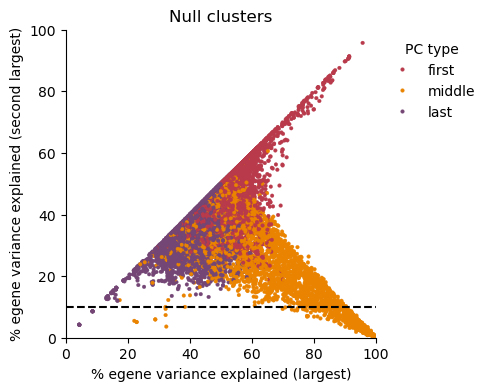

In [230]:
# make the plot
pc_cutoff = 10

fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(pc_annotated_largest, x='egene_r2_1', y='egene_r2_2', hue="pc_order", s=7, edgecolor=None, ax=ax,
                palette={'first':'#B83A4B', 'middle':'#E98300', 'last':'#734675'})

# Set labels
ax.set_xlabel('% egene variance explained (largest)')
ax.set_ylabel('% egene variance explained (second largest)')
ax.set_title('Null clusters')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.hlines(pc_cutoff, 0, 100, color='k', linestyle='--')


# Show the plot
ax.legend(title='PC type', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [231]:
null_clusters['cluster_id'] = ['_'.join([*sorted(t.split(','))]) for t in null_clusters['Transcripts']]
pc_annotated_largest = pd.merge(pc_annotated_largest, null_clusters, on='cluster_id', how='left')

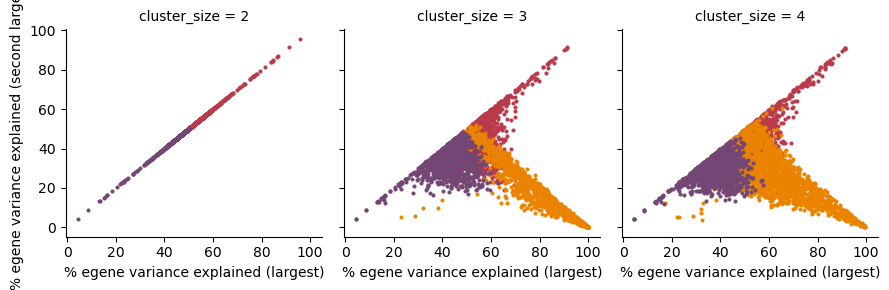

In [232]:
g = sns.FacetGrid(pc_annotated_largest, col="cluster_size", hue="pc_order",
                palette={'first':'#B83A4B', 'middle':'#E98300', 'last':'#734675'})
g.map(sns.scatterplot, "egene_r2_1", "egene_r2_2",  s=7, edgecolor=None,)
g.set_axis_labels("% egene variance explained (largest)", "% egene variance explained (second largest)")


<AxesSubplot: xlabel='Mean_cor', ylabel='Count'>

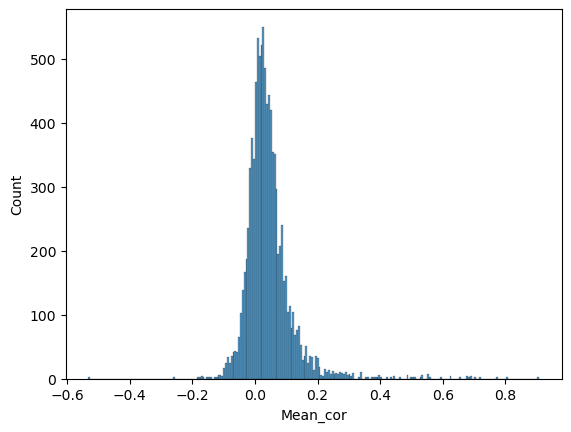

In [233]:
sns.histplot(pc_annotated_largest, x='Mean_cor')

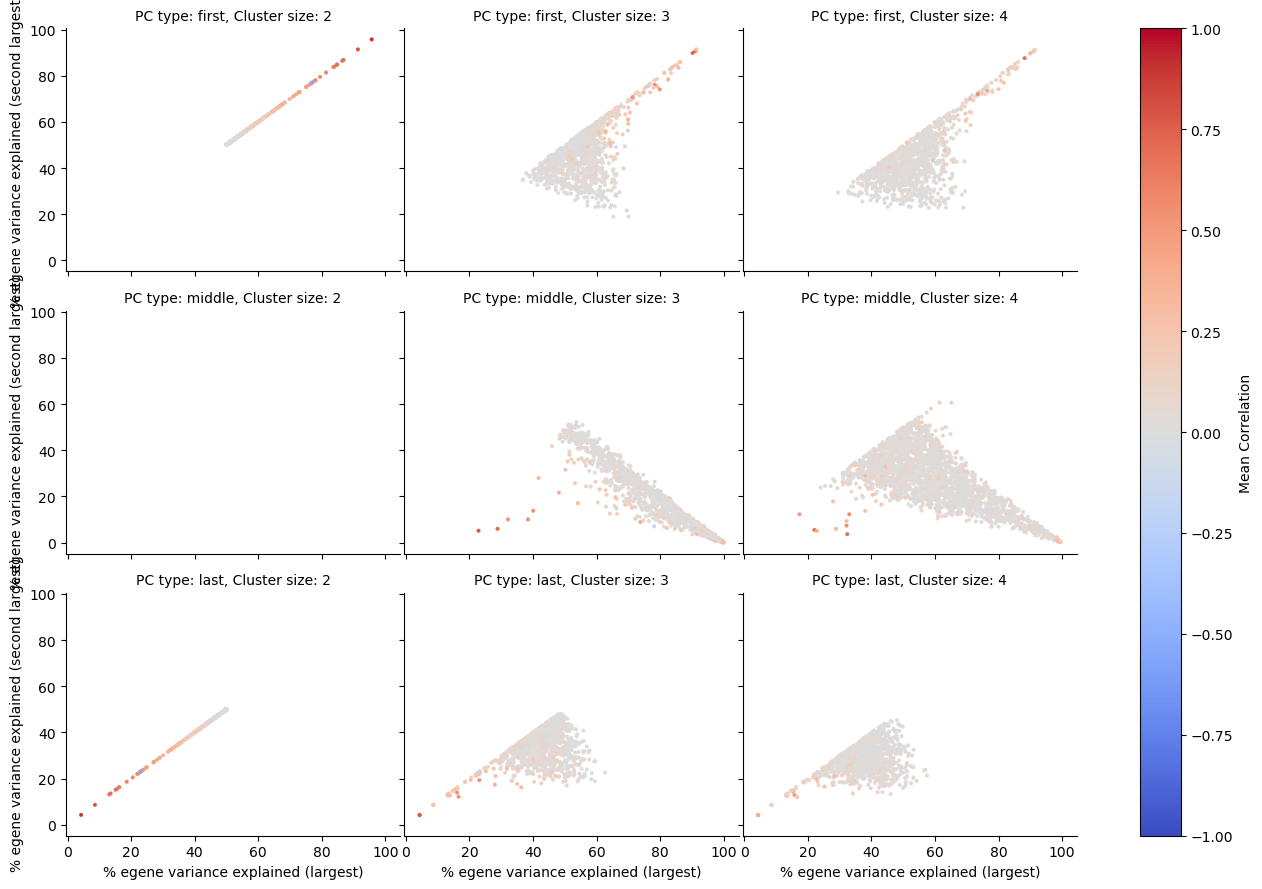

In [237]:
fig = sns.relplot(data=pc_annotated_largest, x="egene_r2_1", y="egene_r2_2", edgecolor=None, s=7,
            col="cluster_size", row="pc_order", hue='Mean_cor', palette="coolwarm",
            hue_norm=(-1, 1), legend=False,
            height=3, aspect=1.5)

fig.set_axis_labels("% egene variance explained (largest)", "% egene variance explained (second largest)") .set_titles("PC type: {row_name}, Cluster size: {col_name}").tight_layout(w_pad=0)

# # Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)  # Normalization for Mean_cor
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
# Add colorbar to the figure
cbar = fig.fig.colorbar(sm, ax=fig.axes.flatten(), orientation='vertical')
cbar.set_label('Mean Correlation')

where do the clusters fall on this?

In [239]:
clusters = load_cluster(config, tissue_id)

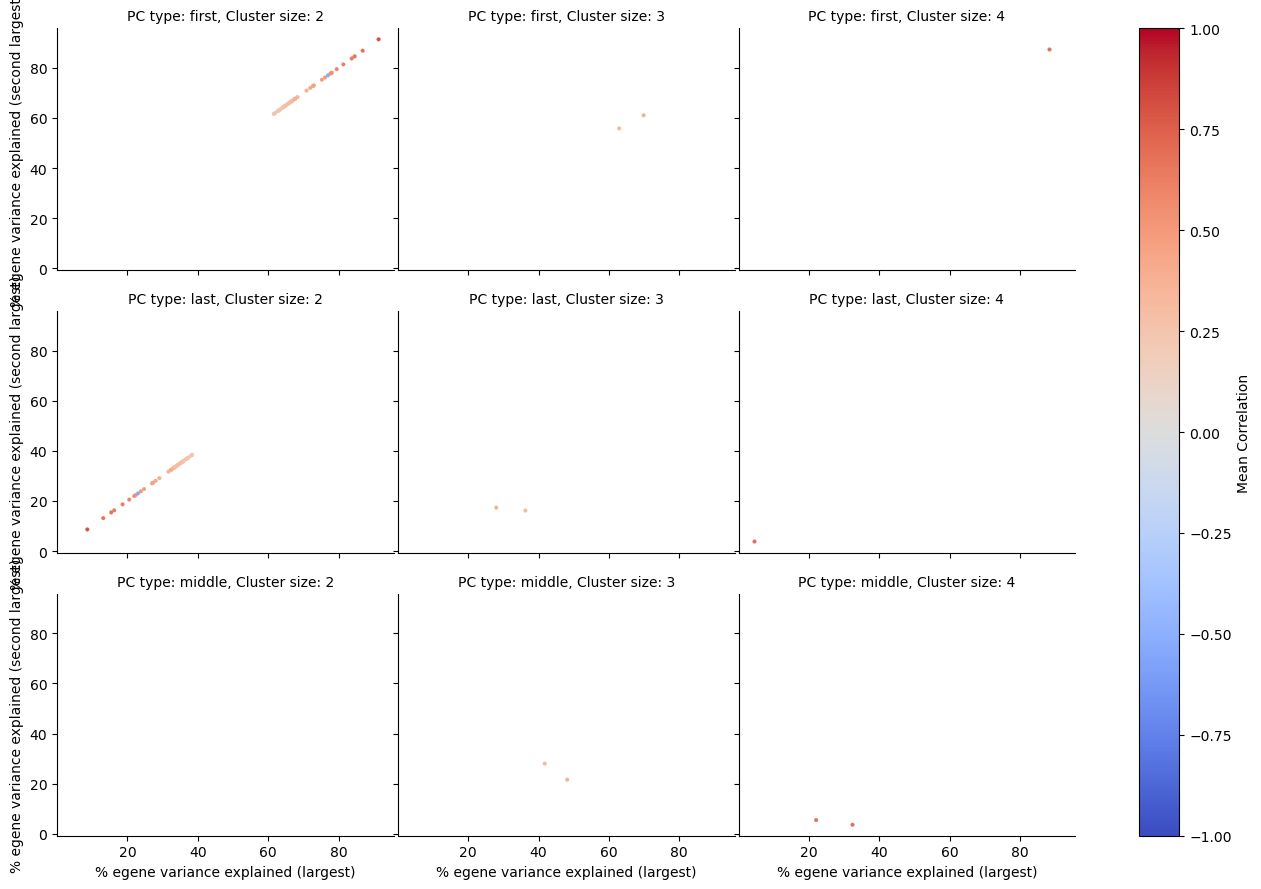

In [242]:
fig = sns.relplot(data=pc_annotated_largest[pc_annotated_largest['cluster_id'].isin(clusters['cluster_id'])], x="egene_r2_1", y="egene_r2_2", edgecolor=None, s=7,
            col="cluster_size", row="pc_order", hue='Mean_cor', palette="coolwarm",
            hue_norm=(-1, 1), legend=False,
            height=3, aspect=1.5)

fig.set_axis_labels("% egene variance explained (largest)", "% egene variance explained (second largest)") .set_titles("PC type: {row_name}, Cluster size: {col_name}").tight_layout(w_pad=0)

# # Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)  # Normalization for Mean_cor
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
# Add colorbar to the figure
cbar = fig.fig.colorbar(sm, ax=fig.axes.flatten(), orientation='vertical')
cbar.set_label('Mean Correlation')